# Projeto prático
## Machine Learning / Disciplina Algoritmos Não-Supervisionados para clusterização [22E4_2]
### Wilson Falcão
##### [Click aqui para acessar o GitHub do trabalho (https://github.com/wilsonfalcao/clusterizacao-trabalho-infnet)](https://github.com/wilsonfalcao/clusterizacao-trabalho-infnet)

###### Importando dependências para uso deste projeto

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
import scipy.cluster.hierarchy as hier
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [2]:
social_economic_csv = pd.read_csv("Country-data.csv", sep=",",index_col=0)

###### Exibindo as 6 primeiras linhas (validando a leitura dados do csv)

In [3]:
social_economic_csv.head(6)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300


> Quantos países existem no dataset?

In [4]:
print(len(social_economic_csv.index.unique()))

167


### Fase de análise exploratória do dado obtido e pré-processamento
> Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

###### Chamando a função describe com atributo T (Transpose), do qual muda o posicionamento das features para exibição do gráfico. Desta forma é visto a média, desvio, minimo, a faixa de valores com amostras de 25,50,75% para cada coluna. Abaixo verificamos uma informação que traduz bem quais são os tipos de problemas enfrentaremos com essa base, olhando a tabulação, temos as features gdpp, inflation, income e child_mort apresentando o desvio muito maior que a média.

In [5]:
social_economic_csv.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


###### Criando a variável de correção e exibindo. O uso da função de correção implica a análise da relação dos valores entre uma ou mais features de uma matriz. Para esse projeto, usaremos na exploração do dado a fim de obter apenas uma estrutura mais coesa para classificação, considerando o Coeficiente de Correlação de Person. Faremos a clusterização considerando as features por coeficiente de correlação entre 0.3 a 1, levando em conta as demais colunas no intuito de diminuir a amplitude e melhorar desempenho. Neste caso apenas consideraremos: export, life_expec, gdpp, income, health

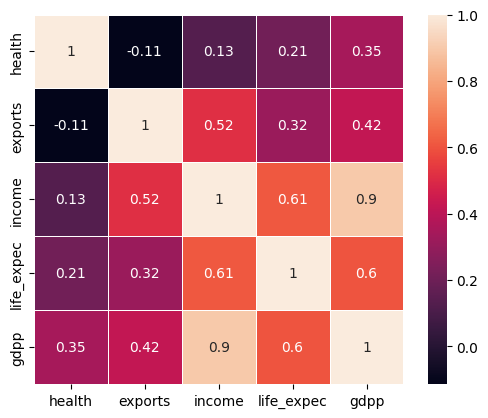

In [6]:
social_matriz = social_economic_csv # export health income life_expect
sm_social_economic = social_matriz[["health","exports","income","life_expec","gdpp"]]
social_matriz_corr = sm_social_economic.corr()
sns.heatmap(social_matriz_corr, square=True, linewidths=.5, annot=True);

##### Obtida a nova estrutura da matriz, onde a feature gdpp possui o coeficiente muito forte com income e forte para life_expec, daremos início ao pré-processamento do dado na tentativa de descobrir outliers e isola-los da clusterização

###### Com uso de uma amostragem de dados menor não foi possível encontrar uma maior correlação e isolamento de outliers. Para este caso, faremos uma condicional que apenas considerará valores de gdpp (Gross Domestic Product Population/PIB) 50% do desvio e abaixo da máxima pela média, desta forma obtendo uma mostragem de 56 em vez de 167. 

> Realize o pré-processamento adequado dos dados.

In [7]:
# Primeira amostragem de dados com valores abaixo ou igual mean + std
sm_gdpp_social = sm_social_economic[sm_social_economic["gdpp"].between((sm_social_economic["gdpp"].std() * 0.5),(sm_social_economic["gdpp"].max() - sm_social_economic["gdpp"].mean()))]
# Matriz sem o uso de equalização, deixando todos os países.
sm_gdpp_social_non_equal = sm_social_economic
sm_gdpp_social.describe().T

,count,mean,std,min,25%,50%,75%,max
health,56.0,7.901250,3.015350,1.81,6.015,8.035,9.5625,17.9
exports,56.0,52.596429,32.881473,10.70,29.175,47.800,66.1750,200.0
income,56.0,36389.285714,19280.038463,14500.00,22600.000,33100.000,42975.0000,125000.0
life_expec,56.0,78.033929,3.798960,60.90,76.075,79.300,80.5500,82.8
gdpp,56.0,30676.785714,18262.738927,10300.00,13500.000,27450.000,44425.0000,87800.0


###### Através da função corr() é exibido a tabulação de correlação de cada feature, onde 1 é apenas a referência de correlação da feature por ela mesma. Desta forma, a informação acima demonstra que a tentativa de eliminar outliers da matriz pela fórmula ((mean - std) e (max - std)). Daremos progresso a próxima etapa através desse dado base.

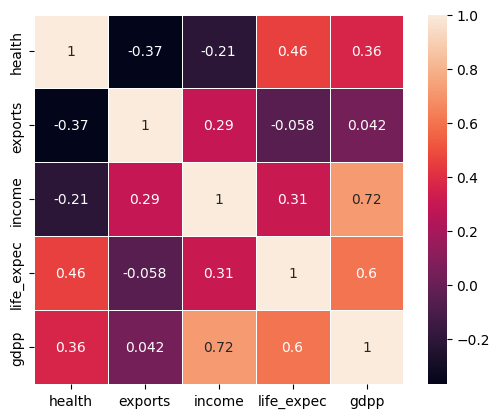

In [8]:
#sm_gdpp_social = sm_social_economic # Obtendo o valor padrão da planilha
sns.heatmap(sm_gdpp_social.corr(), square=True, linewidths=.5, annot=True);

#### O objetivo desse projeto será responder a questões do enunciado sobre a perspectiva dos dados com correlação fraco a alto do GDPP(PIB). Neste ponto de vista, faremos a clusterização onde pontos centroids indicam similaridade dos 43 países.

###### Outra forma de verificar correlação é uso da função pairplot, do qual é possível verificar relação distribuída do dataset. Abaixo é possível verificar a diferença entre o dataset antes do pré-processamento e após dele, é notável que, os dados pré-processados (figura 02) são melhores distribuídos do que matriz base (figura 01).

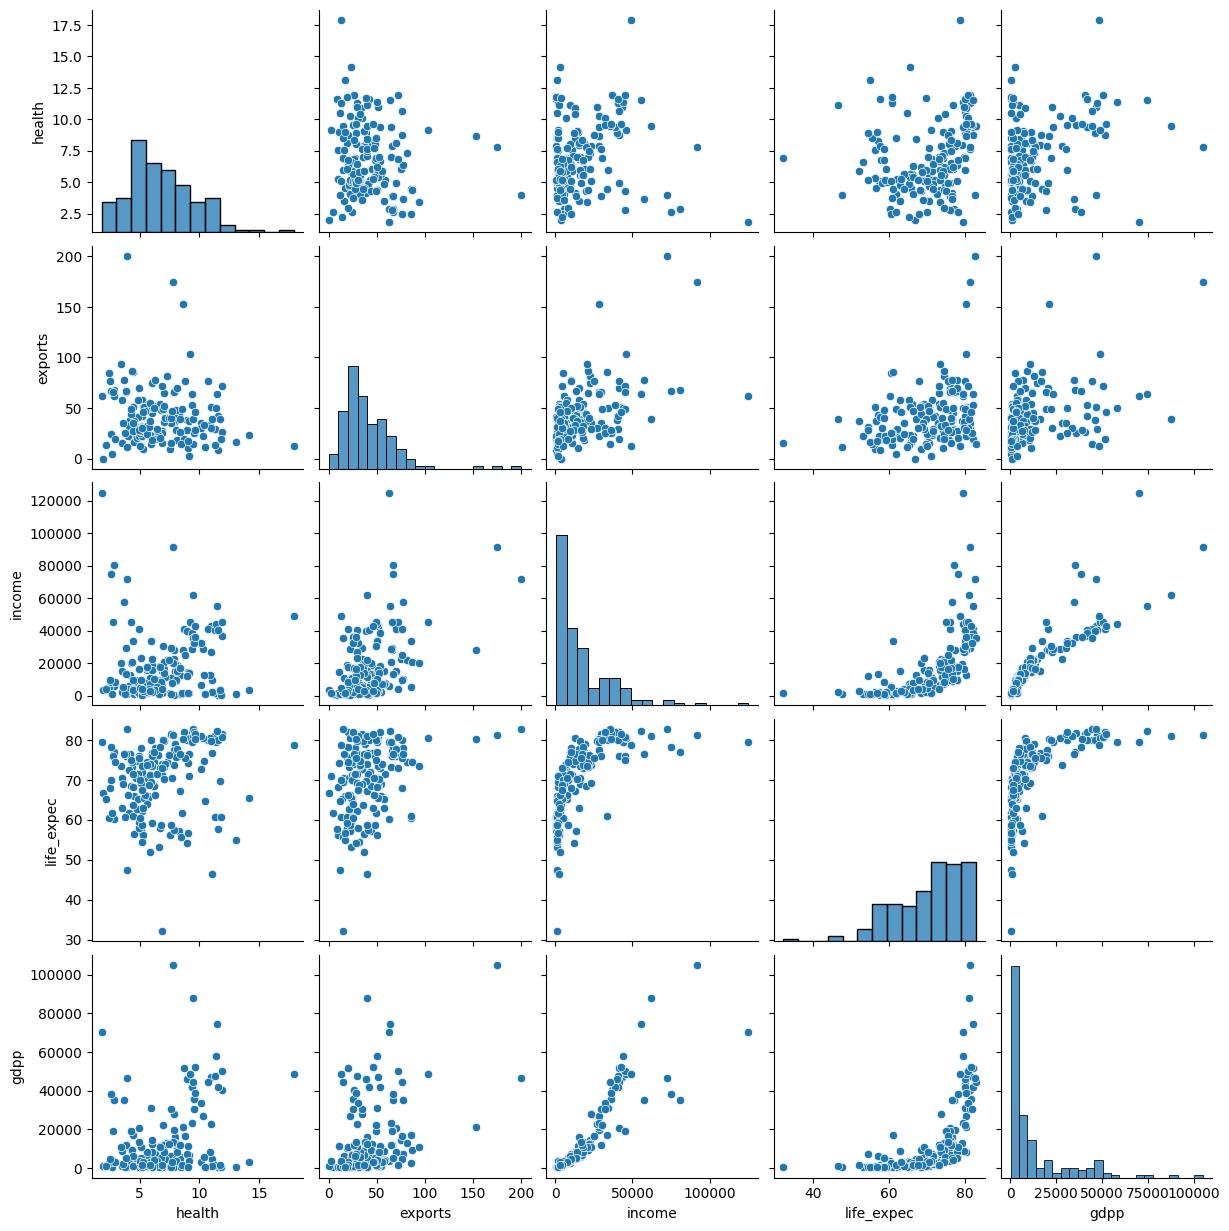

In [9]:
# Figura 01
sns.pairplot(sm_social_economic)

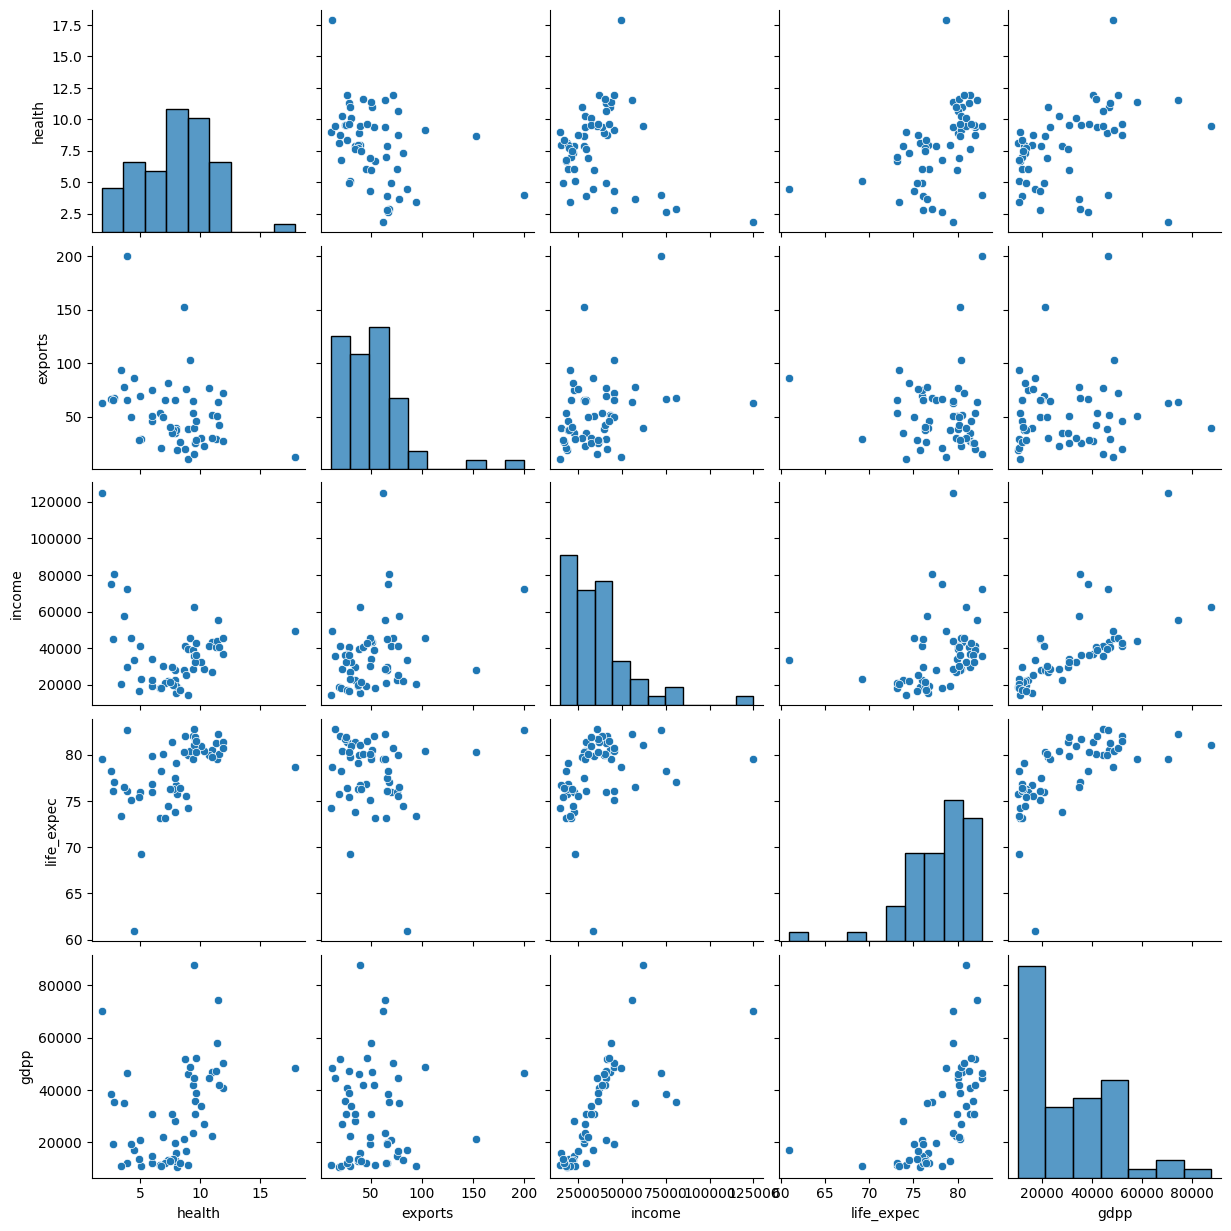

In [10]:
# Figura 02
sns.pairplot(sm_gdpp_social)

###### Com tudo, através do gráfico acima, ainda podemos visualizar a distribuição de alguns valores/plots distantes do baricentro. Faremos a normalização do dataset na tentiva de diminuir a distância euclidiana entre os pontos. Desta vez, usaremos a fórmula (subtrair pela média e dividir pelo desvio) e não a função scale do scikitlearning.

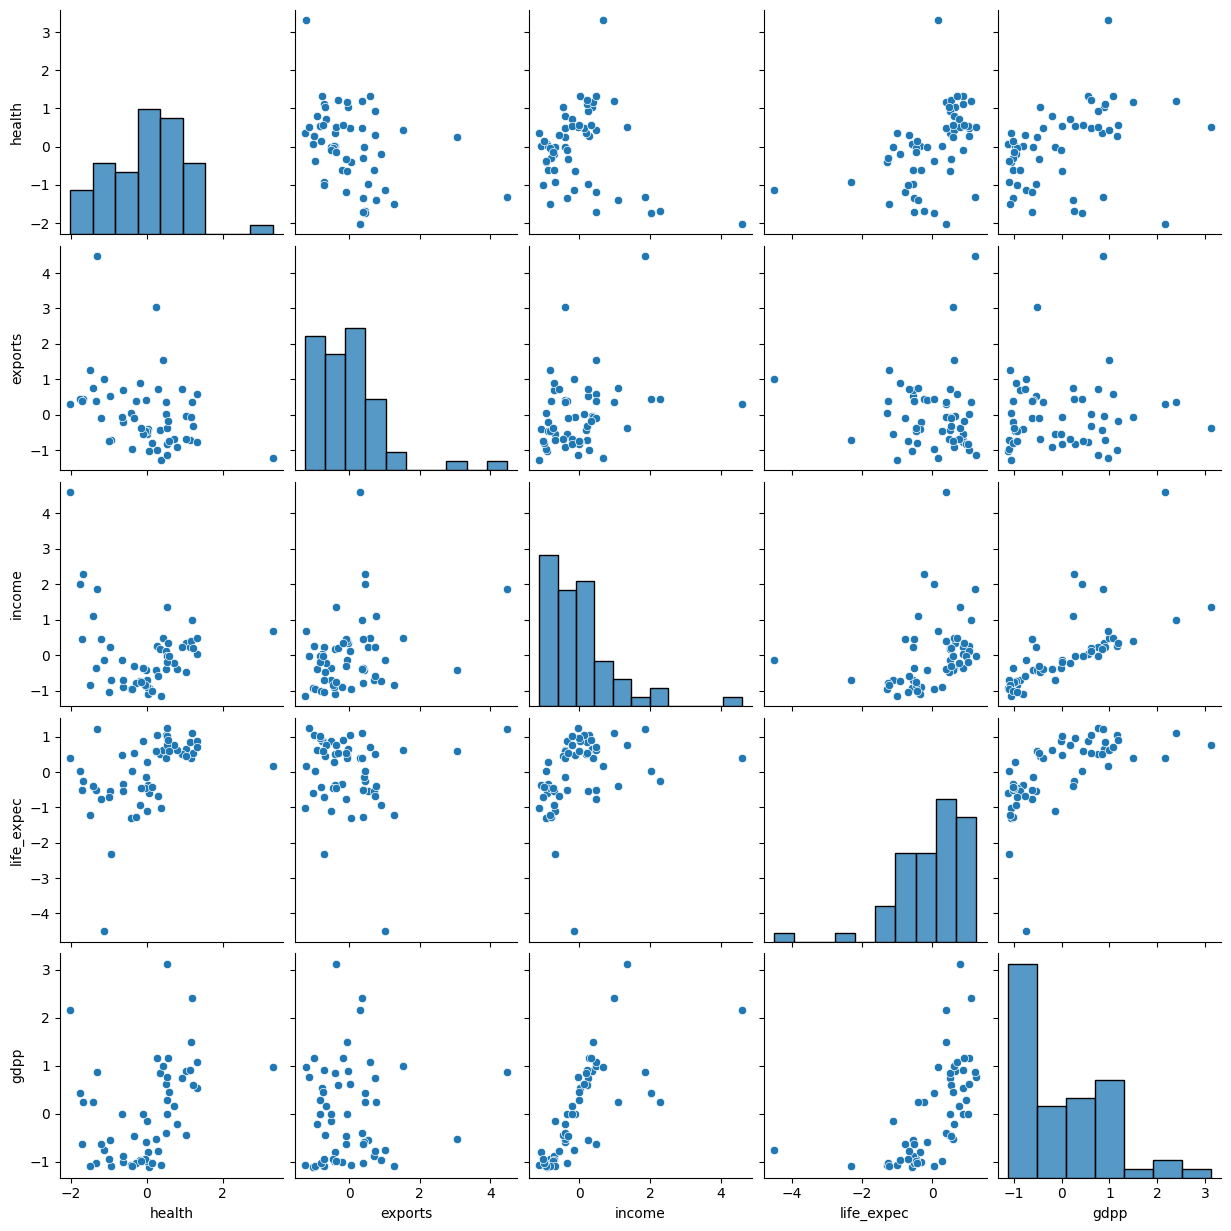

In [11]:
# A normalização será dada pelo valor real menos a média, divido pelo desvio. 
sm_social_normalized = (sm_gdpp_social-sm_gdpp_social.mean())/sm_gdpp_social.std()
sm_social_normalized_non_equal = (sm_gdpp_social_non_equal-sm_gdpp_social_non_equal.mean())/sm_gdpp_social_non_equal.std()
sns.pairplot(sm_social_normalized)

###### Função fornecida em ambiente virtual para plotar/descobrir o melhor N para clusterização através da interpretação do gráfico de cotovelo.

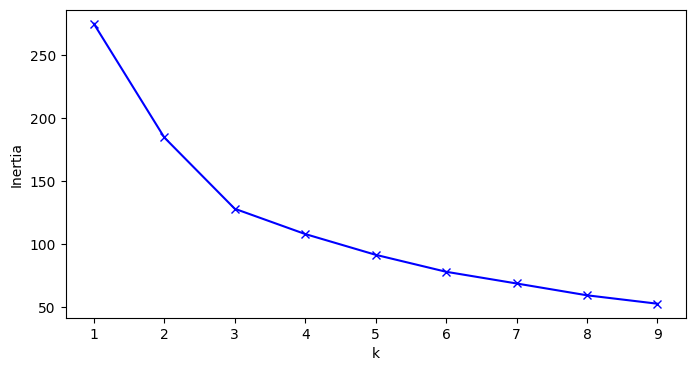

In [12]:
def plot_inertia(df, kmin=1, kmax=10, figsize=(8, 4)):

    _range = range(kmin, kmax)
    inertias = []
    for k in _range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=figsize)
    plt.plot(_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.show()
    
plot_inertia(sm_social_normalized)

###### Através da interpretação do gráfico é obtido o valor de k = 3. Desta forma, o gráfico de cotovelo talvez poderia entregar o número de clusters próximo de um cenário requirido

### Daremos início a fase de clusterização do dataset

> Realizar o agrupamento dos países em 3 grupos distintos. Para tal, use: K-Médias e Clusterização Hierárquica

In [13]:
kmeans = KMeans(n_clusters=3)
k_social_life_expect = kmeans.fit(sm_social_normalized)
sm_social_economic_clusters = sm_gdpp_social.copy()
sm_social_economic_clusters["k_clusters"] = k_social_life_expect.labels_
sm_social_economic_clusters_colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', sm_social_economic_clusters["k_clusters"]))
sm_social_economic_clusters

,health,exports,income,life_expec,gdpp,k_clusters
country,,,,,,
Antigua and Barbuda,6.03,45.5,19100,76.8,12200,2
Argentina,8.10,18.9,18700,75.8,10300,2
Australia,8.73,19.8,41400,82.0,51900,1
Austria,11.00,51.3,43200,80.5,46900,1
Bahamas,7.89,35.0,22900,73.8,28000,2
Bahrain,4.97,69.5,41100,76.0,20700,2
Barbados,7.97,39.5,15300,76.7,16000,2
Belgium,10.70,76.4,41100,80.0,44400,1
Brazil,9.01,10.7,14500,74.2,11200,2


##### Acima a relação de cada país pelo seu agrupamento, dela podemos observar que Brasil, Argentina e Venezuela (países emergentes) foram classificadas no mesmo grupo, seguindo pelas superpotências Estados Unidos, Reino Unido e Alemanha

In [14]:
sm_social_economic_clusters.groupby("k_clusters").mean()

,health,exports,income,life_expec,gdpp
k_clusters,,,,,
0,2.980000,94.820000,82100.000000,78.800000,45140.000000
1,10.513478,40.730435,40265.217391,80.891304,45417.391304
2,6.634286,54.803571,25042.857143,75.550000,15985.714286


###### Acima vemos que após a clusterização, foi classificado cada pais com a seguinte ordenação (média): No cluster 0, os países com a menor concentração de PIB e expectativa de vida e o segundo maior em média com despesas com saúde. No cluster 1, os países com maior concentração de PIB, o primeiro com a maior média de expectativa de vida e gastos com saúde. No cluster 2, os países que representam a maior média de exportação e renda per capita, segundo maior PIB e expectativa de vida com a menor média com despesa em saúde.

In [15]:
centroids = k_social_life_expect.cluster_centers_
sm_social_economic_clusters["k_clusters"].value_counts()

2    28
1    23
0     5
Name: k_clusters, dtype: int64

In [16]:
centroids

array([[-1.63206601,  1.28411436,  2.37088294,  0.20165291,  0.79195209],
       [ 0.86631017, -0.36087172,  0.2010334 ,  0.75214675,  0.80714101],
       [-0.42017157,  0.06712421, -0.58850653, -0.65384428, -0.80442871]])

###### Foram classificados: 23 países para o cluster 0, 28 países para o cluster 1 e 5 para o cluster 2

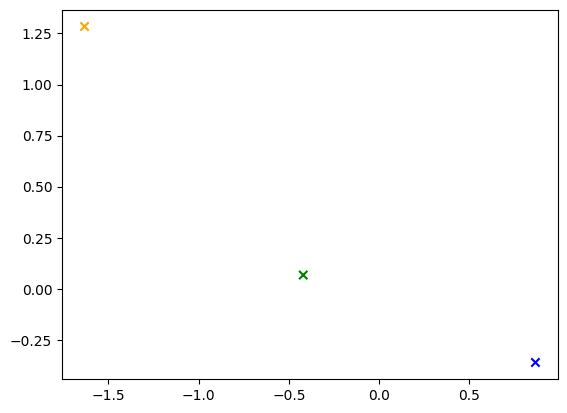

In [17]:

plt.scatter(centroids[:,0],centroids[:,1],marker = "x",c=['orange', 'blue','green'])

In [18]:
sm_social_normalized[sm_social_normalized["gdpp"] >= 0.8]

,health,exports,income,life_expec,gdpp
country,,,,,
Australia,0.274844,-0.997414,0.259891,1.043989,1.162105
Austria,1.027659,-0.039427,0.353252,0.649144,0.888323
Canada,1.127149,-0.714580,0.223584,0.859728,0.915701
Denmark,1.160313,-0.063757,0.394746,0.385914,1.496118
Finland,0.347804,-0.422622,0.176904,0.517529,0.849994
Ireland,0.427397,1.532887,0.482920,0.622821,0.986885
Netherlands,1.326131,0.590107,0.472546,0.701790,1.074495
Norway,0.523571,-0.392210,1.343914,0.780759,3.127856
Qatar,-2.020081,0.295108,4.595982,0.385914,2.169621


##### Observando os valores dos pontos centroids para o cluster 2, vemos que os países que melhor representam esse centroid possuem o valor mais próximo da média é Singapura e Qatar.

In [19]:
# Função de plot de distribuição para algoritimos do Kmeans
def plot_cluster_points(df, kmeans):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data)

# Função de plot de distribuição para algoritimos do dbScan
def plot_dbScan_points(df, dbscan):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cors'] = pd.Categorical(dbscan.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cors", data=pca_data)

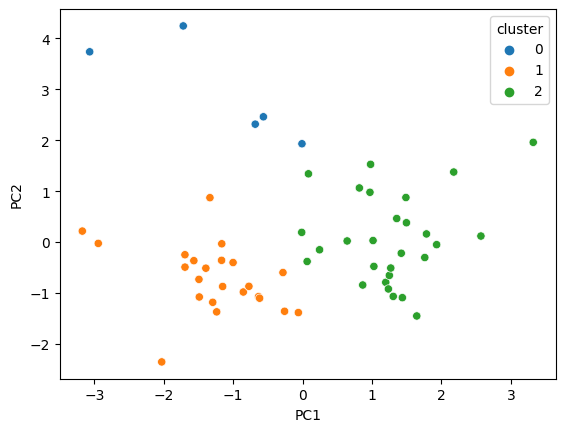

In [20]:
plot_cluster_points(sm_social_normalized, kmeans)

###### Através do gráfico de distribuição podemos verificar que apenas o cluster 0 possui uma aglomeração mais homogênea e o cluster 2 uma inconformidade de distâncias. 

c:\Users\Viana e Moura\Desktop\Trabalho para entrega\projeto\env\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)


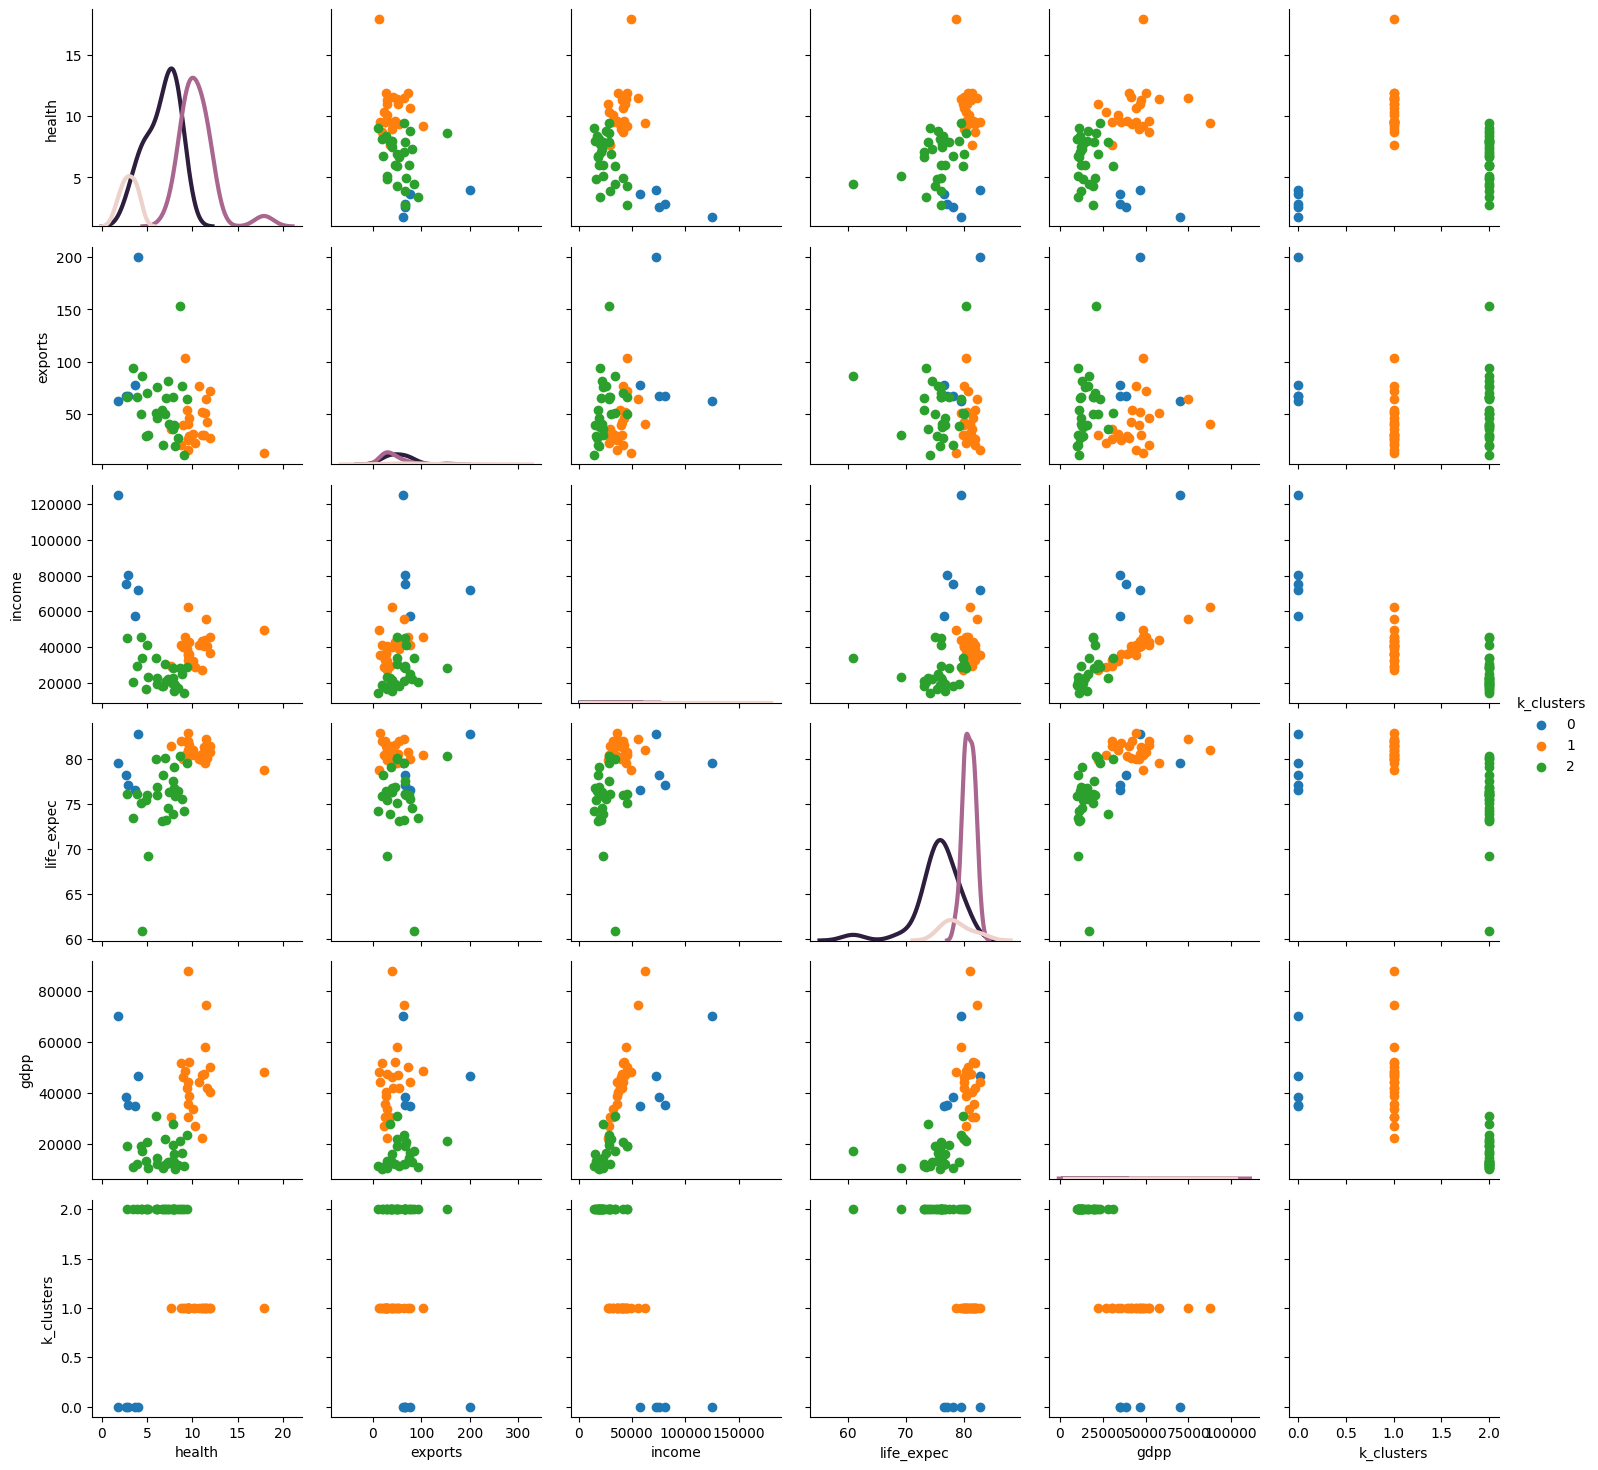

In [21]:
g = sns.PairGrid(sm_social_economic_clusters,vars=sm_social_economic_clusters.columns.values.tolist(),hue="k_clusters")
g.map_diag(sns.kdeplot, lw=3)
g.map_offdiag(plt.scatter)
#g.map(plt.scatter) todas as celulas serao scatter.
g.add_legend()

#####  Com gráfico Pair Grid temos a distribuição correlacionada, onde podemos afirmar uma distribuição quase linear do PIB (GDPP) com expectativa de vida (life_expec) entre todos os clusters. É correto afirmar que o clusters 2, onde apresenta a minoria dos países e maior amplitude de valores do dataset possui uma melhor divisão quando a correlação é com a feature Renda per capita (income). 
> Para os resultados da Clusterização Hierárquica, apresente o dendograma e interprete os resultados

Text(0, 0.5, 'Euclidean Distance')

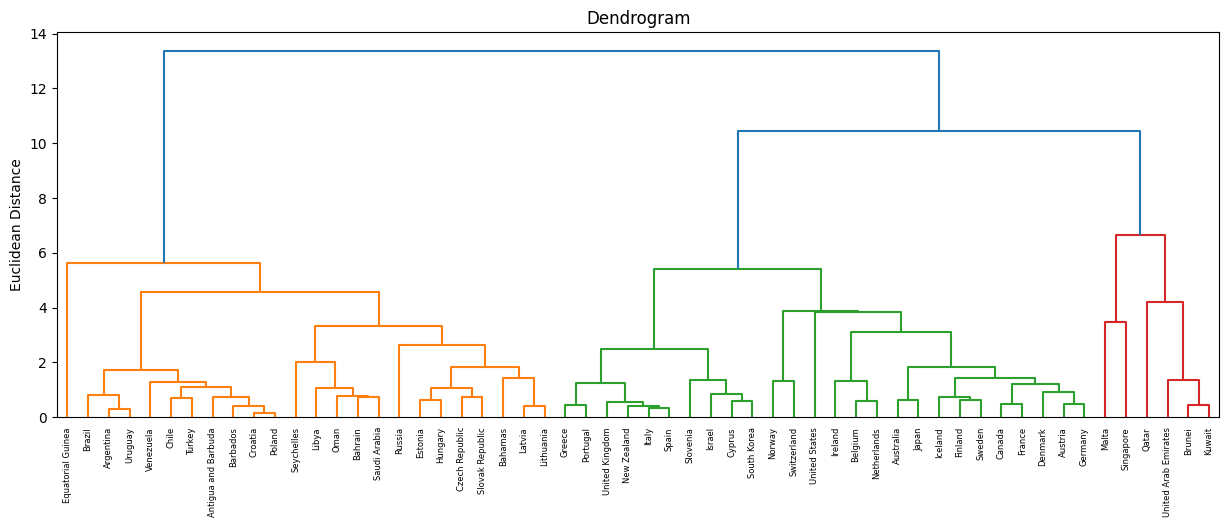

In [22]:
plt.figure(figsize=(15, 5))
plt.grid(False)
dendrogram = hier.dendrogram(hier.linkage(sm_social_normalized, method='ward'), labels=sm_social_normalized.index)
plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')

#### Acima podemos visualizar o Dendograma hierárquico de clusterização, esse diagrama apresenta outra abordagem de clusterição que permite analisar cada dado e classificá-los por método quantitativo, desforma criando um conjunto de classes agrupadas e ordenadas de forma hierárquica. A partir do plot do Dendograma acima, podemos dá as seguintes observações:

+ De mesma forma do qual foi clusterizado pelo Kmeans do scikit-learning, foram divididos em três classes no modelo hierárquico. O que podemos dizer que atualmente a classe 3 possui a menor quantidade de países (no total de  6) e maior amplitude de valor (algo já visto no Kmeans), mas não com os mesmos países.
+ A faixa de valores de classe 3 é visivelmente maior do que as demais classes, colocando-a distante dos outros conjuntos. 
+ Na classe 2 tem o maior número de países semelhantes (com a mesma faixa de valor).
+ É correto afirma que para todas as classes, a perna esquerda de cada conjunto possui uma faixa de valor menor em relação a sua direita. 
+ Há regiões de confusão em todas as classes, sendo maior a distância na classe 03.

In [23]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    hier.dendrogram(linkage_matrix, **kwargs)


# from sklearn.cluster import AgglomerativeClustering
sm_gdpp_h_ch = AgglomerativeClustering(n_clusters=3)
sm_gdpp_h_ch.fit(sm_social_normalized)
sm_social_economic_clusters["hier_clusters"] = sm_gdpp_h_ch.labels_
sm_social_economic_clusters

,health,exports,income,life_expec,gdpp,k_clusters,hier_clusters
country,,,,,,,
Antigua and Barbuda,6.03,45.5,19100,76.8,12200,2,1
Argentina,8.10,18.9,18700,75.8,10300,2,1
Australia,8.73,19.8,41400,82.0,51900,1,2
Austria,11.00,51.3,43200,80.5,46900,1,2
Bahamas,7.89,35.0,22900,73.8,28000,2,1
Bahrain,4.97,69.5,41100,76.0,20700,2,1
Barbados,7.97,39.5,15300,76.7,16000,2,1
Belgium,10.70,76.4,41100,80.0,44400,1,2
Brazil,9.01,10.7,14500,74.2,11200,2,1


> Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

##### Analisando os dois resultados por tipos de clusterização obtêm 32 países clusterizado em clusters diferentes e 24 em clusters iguais, o que podemos afirmar que a média de valores das features foram maiores nas diferenças do que da similaridade. Significa dizer que os algoritmos classificaram os dados de forma igual quando a faixa de valor era menor e diferente quando maior. Extraindo as diferenças de cada cluster é visto que as alocações entre o Kmeans e o Hierárquico foram entre os clusters 0 e 2, sendo possível associar essa troca porque possuem os mesmos países apontados, com a diferença de Malta sendo melhor classificado no modelo Kmeans, isto pelo enquadramento do país entre aqueles que fazem parte do cluster 1. Também é visto através do gráfico Pair Grid que as regiões de confusões entre os cluster 0 e 2 foram maiores quando correlacionados com life_expec, income e GDPP.

In [24]:
sm_clusters_df = sm_social_economic_clusters[sm_social_economic_clusters["k_clusters"] != sm_social_economic_clusters["hier_clusters"]]
sm_clusters_eq = sm_social_economic_clusters[sm_social_economic_clusters["k_clusters"] == sm_social_economic_clusters["hier_clusters"]]
sm_social_economic_clusters[sm_social_economic_clusters["hier_clusters"] == 0]

,health,exports,income,life_expec,gdpp,k_clusters,hier_clusters
country,,,,,,,
Brunei,2.84,67.4,80600,77.1,35300,0,0
Kuwait,2.63,66.7,75200,78.2,38500,0,0
Malta,8.65,153.0,28300,80.3,21100,2,0
Qatar,1.81,62.3,125000,79.5,70300,0,0
Singapore,3.96,200.0,72100,82.7,46600,0,0
United Arab Emirates,3.66,77.7,57600,76.5,35000,0,0


In [25]:
sm_clusters_df.mean()

health               8.442917
exports             48.070833
income           31964.583333
life_expec          77.841667
gdpp             29497.916667
k_clusters           1.520833
hier_clusters        1.458333
dtype: float64

Text(0, 0.5, 'Distância Euclideana')

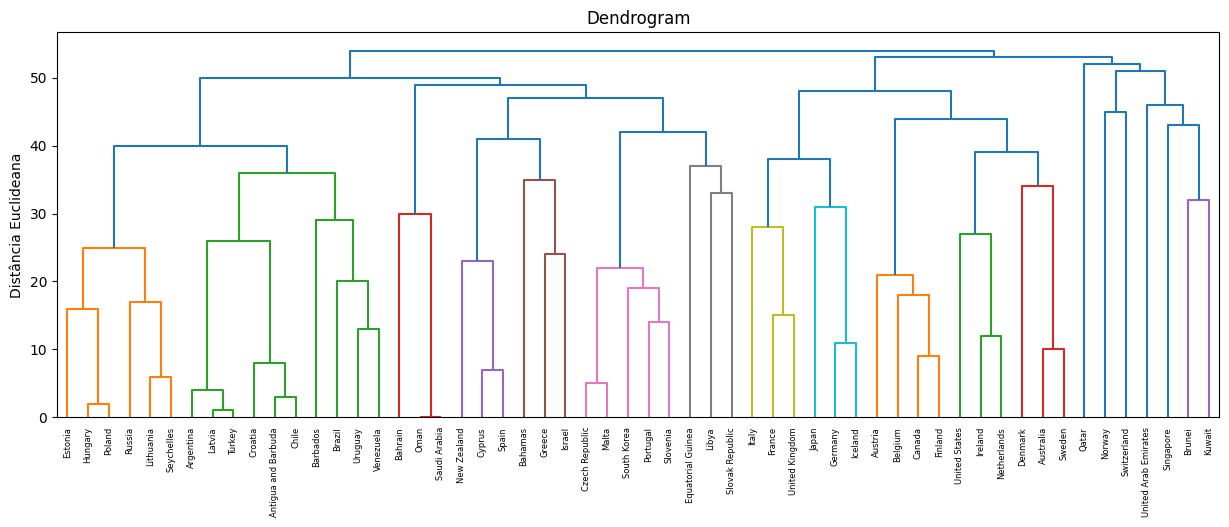

In [26]:
sm_gdpp_h_ch_pred = sm_gdpp_h_ch.fit_predict(sm_gdpp_social)

plt.figure(figsize=(15, 5))
plt.grid(False)
plot_dendrogram(sm_gdpp_h_ch, labels=sm_gdpp_social.index)
plt.title('Dendrogram')
plt.ylabel('Distância Euclideana')

#### Implementando a clusterização por DBScan

In [27]:
epsilon = 1
min_samples = 10

db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(sm_social_normalized)
labels = db.labels_


In [28]:
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 3
Estimated no. of noise points: 27


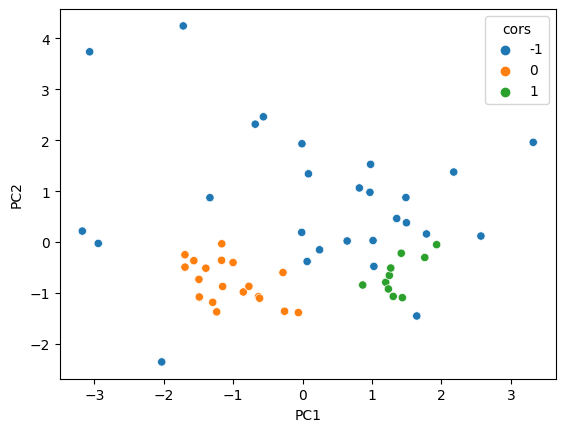

In [29]:
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', db.labels_))

plot_dbScan_points(sm_social_normalized, db)

> Por que o algoritmo de DBScan é mais robusto à presença de outliers?

###### Tendo em vista o principal problema de todos os algoritmos de clusterização (a amplitude e faixa de valor), o DBSCAN acaba sendo a uma das formas para detecção de anomalias de valores. Além de, uso do algorítimo em vez da forma matemática na análise de similaridade por densidade (cors, epsion, noise) e classificação, não faz necessário o parâmetro de N de clusters, permitindo um melhor entendimento do dataset quanto a descoberta arbitrária de "classes". Exemplificando melhor essa vantagem do DBSCAN, faremos abaixo o mesmo uso (visto em cima) deste algorítimo, eliminando a etapa de pré-processamento (do qual tentei equalizar a faixa de valor tentando excluir os países que estavam em fronteira). Vejamos:

> Como o DBScan funciona? 

O DBScan tem uma abordagem de agrupamento baseado na densidade de pontos, onde uma determinada região é responsável pela formação dos clusters. Caso um determinado ponto não obedeça critérios de densidade(vizinhos mínimos) ou critérios dos limites de distância (epson), este não pode ser definido como um ponto COR.

In [30]:
epsilon = 1 #Distância mínima entre pontos
min_samples = 10 #Dencidade mínima de vizinhos

db2 = DBSCAN(eps=1, min_samples=10).fit(sm_social_normalized_non_equal) # Instanciando o DBScan e passando os parâmetros de Epson e qunatidade de vizinhos mínmos
# A função fit realiza a clusterização obtendo labels dessa ação de classificação dos dados.

In [31]:
labels2 = db2.labels_
no_clusters = len(np.unique(db2.labels_) )
no_noise = np.sum(np.array(db2.labels_) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 3
Estimated no. of noise points: 36


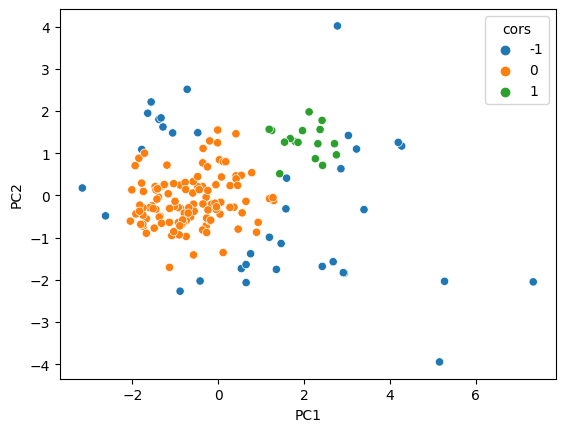

In [32]:
plot_dbScan_points(sm_social_normalized_non_equal, db2)

In [33]:
sm_social_econmic_cluster_db = sm_social_economic.copy()
sm_social_econmic_cluster_db["cluster"]= labels2
sm_social_econmic_cluster_db[sm_social_econmic_cluster_db["cluster"] == -1].describe().T

,count,mean,std,min,25%,50%,75%,max
health,36.0,7.700556,4.160728,1.81,3.940,8.21,11.325,17.9
exports,36.0,61.511667,45.085548,2.20,22.400,64.15,76.725,200.0
income,36.0,33554.500000,30694.767079,700.00,3100.000,31650.00,46625.000,125000.0
life_expec,36.0,70.805556,11.964374,32.10,63.675,76.05,79.600,82.7
gdpp,36.0,26309.111111,27690.162994,231.00,2462.500,19300.00,44950.000,105000.0
cluster,36.0,-1.000000,0.000000,-1.00,-1.000,-1.00,-1.000,-1.0


##### Mesmo diminuindo a quantidade de países através do pré-processamento, o número de ruídos no dataset foi de 27/36 e o gráfico ainda demonstra uma região distante dos clusters reconhecidos. Acima fica ainda mais explicito que a etapa de pré-processamento foi inválida pelo que o DBSCAN conseguiu descobrir de ruídos, deixando nítido que a região de ruído são países que possuem valores de faixa extremos e distantes. 

>  O algoritmo de K-médias é sensível a outliers nos dados. Explique.

#### Sim, mesmo quando há etapas de pré-processamento, as labels obtidas após a clusterização não podem evidenciar registros/pontos que realmente fazem parte do conjunto. Isso é tão evidente quanto qualquer algorítimo que faça uso de fórmula matemática euclidiana. Abaixo deixo um exemplo de Kmeans usando o DBSCAN como pré-processamento de dados, vejamos o quão distante foi do primeiro exemplo.

In [34]:
social_kmeans_dbScan_normalize = sm_social_normalized_non_equal.copy()
social_kmeans_dbScan_normalize["cluster"] = labels2
exemplo_kmeans_dbScan = social_kmeans_dbScan_normalize[social_kmeans_dbScan_normalize["cluster"] != -1]
exemplo_kmeans_dbScan

,health,exports,income,life_expec,gdpp,cluster
country,,,,,,
Afghanistan,0.278251,-1.134867,-0.805822,-1.614237,-0.677143,0
Albania,-0.096725,-0.478220,-0.374243,0.645924,-0.484167,0
Algeria,-0.963176,-0.098824,-0.220182,0.668413,-0.463980,0
Angola,-1.443729,0.773056,-0.583289,-1.175698,-0.514720,0
Antigua and Barbuda,-0.286034,0.160186,0.101427,0.702147,-0.041692,0
...,...,...,...,...,...,...
Vanuatu,-0.569997,0.200315,-0.736313,-0.849606,-0.545273,0
Venezuela,-0.693776,-0.459980,-0.033442,0.544723,0.029235,0
Vietnam,0.008851,1.126916,-0.656429,0.286097,-0.635842,0


###### Faço o mesmo processo de clusterização e depois retido os ruídos

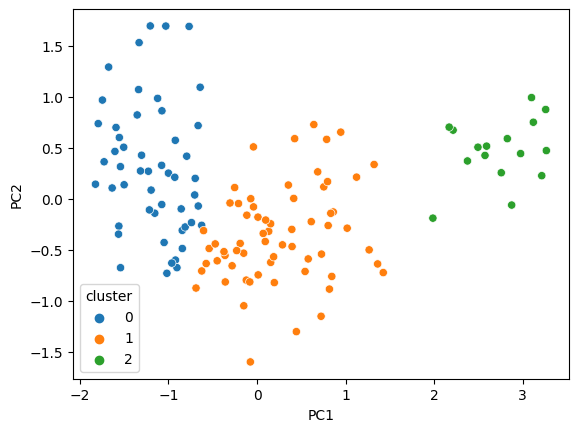

In [35]:
kmeans = KMeans(n_clusters=3)
k_social_dbscan = kmeans.fit(exemplo_kmeans_dbScan.drop("cluster", axis="columns"))
plot_cluster_points(exemplo_kmeans_dbScan,k_social_dbscan)

##### Na imagem acima, instancio o kmeans novamente e passo o mesmo dataset normalizado e sem o ruído. No final obtenho o gráfico de distribuição mais bem classificado